In [1]:
import os
import io
import time
import requests
import json
import pandas as pd
from sklearn import metrics

from credentials import api_keys

In [2]:
df_text = pd.read_json('./data/dev_seen.jsonl', lines=True)
df_text['img'] = df_text['img'].apply(lambda x: './data/' + x)
df_text

,id,img,label,text
0,8291,./data/img/08291.png,1,white people is this a shooting range
1,46971,./data/img/46971.png,1,bravery at its finest
2,3745,./data/img/03745.png,1,your order comes to $37.50 and your white priv...
3,83745,./data/img/83745.png,1,it is time.. to send these parasites back to t...
4,80243,./data/img/80243.png,1,mississippi wind chime
...,...,...,...,...
495,83675,./data/img/83675.png,0,i'm gonna be like phelps one day
496,37198,./data/img/37198.png,0,when you're so relaxed you can feel yourself g...
497,48670,./data/img/48670.png,0,look at this sandwich maker club i found on wi...
498,9863,./data/img/09863.png,0,diverse group of women


## Clarifai Text Moderation Model

In [3]:
from clarifai_grpc.channel.clarifai_channel import ClarifaiChannel
from clarifai_grpc.grpc.api import resources_pb2, service_pb2, service_pb2_grpc
from clarifai_grpc.grpc.api.status import status_pb2, status_code_pb2

stub = service_pb2_grpc.V2Stub(ClarifaiChannel.get_grpc_channel())
metadata = (('authorization', api_keys.CLARIFAI_API_KEY),)

In [4]:
def clarifai_api(text):
    time.sleep(0.2)
    request = service_pb2.PostModelOutputsRequest(
        # This is the model ID of a publicly available General model. 
        # You may use any other public or custom model ID.
        model_id='c1a2ac2adba0204d859fb89fd44d6ac9',
        inputs=[
            resources_pb2.Input(
                data=resources_pb2.Data(
                    text=resources_pb2.Text(
                        raw=text
                    )
                )
            )
        ])
    response = stub.PostModelOutputs(request, metadata=metadata)

    if response.status.code != status_code_pb2.SUCCESS:
        raise Exception("Post model outputs failed, status: " + response.status.description)

    # for concept in response.outputs[0].data.concepts:
    #     print('%13s: %.2f' % (concept.name, concept.value))

    highest_value = 0
    highest_concept = ''
    for concept in response.outputs[0].data.concepts:
        if concept.value > highest_value:
            highest_concept = concept.name
            highest_value = concept.value

    if highest_value < 0.1:
        highest_concept = 'SAFE'

    print('{:>13s}: {:>.5f} - {}'.format(highest_concept, highest_value, text))

    return highest_value

In [5]:
df_text_clarifai = df_text.copy()
df_text_clarifai['pred_cf_value'] = df_text_clarifai['text'].apply(clarifai_api)
df_text_clarifai.to_csv('./results/df_text_clarifai.csv')
print(df_text_clarifai)

         SAFE: 0.00610 - white people is this a shooting range
         SAFE: 0.00010 - bravery at its finest
         SAFE: 0.00006 - your order comes to $37.50 and your white privilege discount brings the total to $37.50
        toxic: 0.77444 - it is time.. to send these parasites back to the desert
         SAFE: 0.00062 - mississippi wind chime
         SAFE: 0.00144 - knowing white people , that's probably the baby father
        toxic: 0.17505 - life hack #23 how to get stoned with no weed
         SAFE: 0.00006 - you've heard of elf on a shelf, now get ready for
         SAFE: 0.05513 - cooooooooooooon!!!!
        toxic: 0.42571 - when you get to choose your own mental illness
        toxic: 0.99877 - dat ass ahmarbkrich*d
        toxic: 0.99651 - look! it says it right here! we can fuck goats!
        toxic: 0.13271 - enough is enough children are more important than freaks
        toxic: 0.98771 - removes polish with chemicals nobody bats an eye removes polish with chemicals 

In [3]:
print('Classification Report for Clarifai Text Moderation API:')
df_text_clarifai = pd.read_csv('./results/df_text_clarifai.csv')
df_text_clarifai['pred_cf'] = df_text_clarifai['pred_cf_value'].apply(lambda x: 1 if x >= 0.5 else 0 )
target_names = ['not-offensive', 'offensive']
print(metrics.classification_report(df_text_clarifai['label'], df_text_clarifai['pred_cf'], target_names=target_names, digits=4))

Classification Report for Clarifai Text Moderation API:
               precision    recall  f1-score   support

not-offensive     0.5301    0.8696    0.6587       253
    offensive     0.6118    0.2105    0.3133       247

     accuracy                         0.5440       500
    macro avg     0.5709    0.5400    0.4860       500
 weighted avg     0.5705    0.5440    0.4880       500



In [19]:
def clarifai_api_hate(text):
    time.sleep(0.2)
    request = service_pb2.PostModelOutputsRequest(
        # This is the model ID of a publicly available General model. 
        # You may use any other public or custom model ID.
        model_id='c1a2ac2adba0204d859fb89fd44d6ac9',
        inputs=[
            resources_pb2.Input(
                data=resources_pb2.Data(
                    text=resources_pb2.Text(
                        raw=text
                    )
                )
            )
        ])
    response = stub.PostModelOutputs(request, metadata=metadata)

    if response.status.code != status_code_pb2.SUCCESS:
        raise Exception("Post model outputs failed, status: " + response.status.description)

    # for concept in response.outputs[0].data.concepts:
    #     print('%13s: %.2f' % (concept.name, concept.value))

    identity_hate_score = response.outputs[0].data.concepts[3].value

    print('identity_hate: {:>.5f} - {}'.format(identity_hate_score, text))
    return identity_hate_score
    # highest_value = 0
    # highest_concept = ''
    # for concept in response.outputs[0].data.concepts:
    #     if concept.value > highest_value:
    #         highest_concept = concept.name
    #         highest_value = concept.value

    # if highest_value < 0.1:
    #     highest_concept = 'SAFE'

    # print('{:>13s}: {:>.5f} - {}'.format(highest_concept, highest_value, text))

    # return highest_value

In [20]:
df_text_clarifai_hate = df_text.copy()
df_text_clarifai_hate['pred_cf_value'] = df_text_clarifai_hate['text'].apply(clarifai_api_hate)
df_text_clarifai_hate.to_csv('./results/df_text_clarifai_hate.csv')
print(df_text_clarifai_hate)

merica voting towel heads into congress
identity_hate: 0.00011 - be careful who you call ugly in highschool
identity_hate: 0.00007 - i'm no bird expert but i'm guessing it's 4 females and 1 male
identity_hate: 0.00006 - wait, mohammad come back i didn't mean to laugh, really size dosen't matter to me lol
identity_hate: 0.00002 - a fast sandwich maker
identity_hate: 0.00006 - waves mexican flag doesn't want to live in mexico
identity_hate: 0.00009 - i'm going home i'm russian
identity_hate: 0.00003 - don't be late for work get the protestor plow
identity_hate: 0.00002 - when you ask the kid that misses class a lot why he is bald and he starts crying all right. then keep vour secrets
identity_hate: 0.00002 - and for my next class project!
identity_hate: 0.00003 - everyone is afraid of dark
identity_hate: 0.02397 - in west philadelphia, born and raised in the anus is where i got most of my aids
identity_hate: 0.00008 - i had potato for lunch
identity_hate: 0.00015 - parental opioid use ha

In [21]:
print('Classification Report for Clarifai Text Moderation API on identity_hate:')
df_text_clarifai_hate = pd.read_csv('./results/df_text_clarifai_hate.csv')
df_text_clarifai_hate['pred_cf'] = df_text_clarifai_hate['pred_cf_value'].apply(lambda x: 1 if x >= 0.5 else 0 )
target_names = ['not-hateful', 'hateful']
print(metrics.classification_report(df_text_clarifai_hate['label'], df_text_clarifai_hate['pred_cf'], target_names=target_names, digits=4))

Classification Report for Clarifai Text Moderation API on identity_hate:
              precision    recall  f1-score   support

 not-hateful     0.5081    0.9960    0.6729       253
     hateful     0.7500    0.0121    0.0239       247

    accuracy                         0.5100       500
   macro avg     0.6290    0.5041    0.3484       500
weighted avg     0.6276    0.5100    0.3523       500



## Perspective API

In [23]:
from googleapiclient import discovery

client = discovery.build(
    "commentanalyzer",
    "v1alpha1",
    developerKey=api_keys.PERSPECTIVE_API_KEY,
    discoveryServiceUrl="https://commentanalyzer.googleapis.com/$discovery/rest?version=v1alpha1",
    static_discovery=False,
)

In [24]:
def perspective_api(text):
    time.sleep(1)
    analyze_request = {
        'comment': { 'text': text },
        'requestedAttributes': {
            'TOXICITY': {},
            'SEVERE_TOXICITY': {},
            'IDENTITY_ATTACK': {},
            'INSULT': {},
            'PROFANITY': {},
            'THREAT': {}
        },
        'languages': ['en']
    }

    response = client.comments().analyze(body=analyze_request).execute()
    # print(json.dumps(response, indent=4))
    highest_key = ''
    highest_value = 0
    for key, value in response['attributeScores'].items():
        temp_val = response['attributeScores'][key]['summaryScore']['value']
        if temp_val > highest_value:
            highest_value = temp_val
            highest_key = key

    print('{:>15s}: {:>.5f} - {}'.format(highest_key, highest_value, text))

    return highest_value

In [25]:
df_text_perspective = df_text.copy()
df_text_perspective['pred_ps_value'] = df_text_perspective['text'].apply(perspective_api)
df_text_perspective.to_csv('./results/df_text_perspective.csv')
print(df_text_perspective)

'm going home i'm russian
IDENTITY_ATTACK: 0.17018 - don't be late for work get the protestor plow
         INSULT: 0.28228 - when you ask the kid that misses class a lot why he is bald and he starts crying all right. then keep vour secrets
         THREAT: 0.06692 - and for my next class project!
IDENTITY_ATTACK: 0.17684 - everyone is afraid of dark
       TOXICITY: 0.83552 - in west philadelphia, born and raised in the anus is where i got most of my aids
       TOXICITY: 0.15427 - i had potato for lunch
         THREAT: 0.41903 - parental opioid use has negative effect on children's intelligence
       TOXICITY: 0.09333 - in 1979 jimmy carter created the department of education since then the u.s. has gone from 1st to 17th in education
       TOXICITY: 0.24023 - when she gives you that look
         THREAT: 0.36830 - a real man loads the dishwasher every night
IDENTITY_ATTACK: 0.74576 - time to put the "panic" back in hispanic
         THREAT: 0.24808 - why do we share more when thes

In [4]:
print('Classification Report for Perspective API:')
df_text_perspective = pd.read_csv('./results/df_text_perspective.csv')
df_text_perspective['pred_ps'] = df_text_perspective['pred_ps_value'].apply(lambda x: 1 if x >= 0.5 else 0 )
target_names = ['not-offensive', 'offensive']
print(metrics.classification_report(df_text_perspective['label'], df_text_perspective['pred_ps'], target_names=target_names, digits=4))

Classification Report for Perspective API:
               precision    recall  f1-score   support

not-offensive     0.5749    0.6522    0.6111       253
    offensive     0.5869    0.5061    0.5435       247

     accuracy                         0.5800       500
    macro avg     0.5809    0.5791    0.5773       500
 weighted avg     0.5808    0.5800    0.5777       500



In [29]:
def perspective_api_hate(text):
    time.sleep(1)
    analyze_request = {
        'comment': { 'text': text },
        'requestedAttributes': {
            'SEVERE_TOXICITY': {},
            'IDENTITY_ATTACK': {}
        },
        'languages': ['en']
    }

    response = client.comments().analyze(body=analyze_request).execute()
    # print(json.dumps(response, indent=4))
    highest_key = ''
    highest_value = 0
    for key, value in response['attributeScores'].items():
        temp_val = response['attributeScores'][key]['summaryScore']['value']
        if temp_val > highest_value:
            highest_value = temp_val
            highest_key = key

    print('{:>15s}: {:>.5f} - {}'.format(highest_key, highest_value, text))

    return highest_value

In [30]:
df_text_perspective_hate = df_text.copy()
df_text_perspective_hate['pred_ps_value'] = df_text_perspective_hate['text'].apply(perspective_api_hate)
df_text_perspective_hate.to_csv('./results/df_text_perspective_hate.csv')
print(df_text_perspective_hate)

'm going home i'm russian
IDENTITY_ATTACK: 0.17018 - don't be late for work get the protestor plow
IDENTITY_ATTACK: 0.08678 - when you ask the kid that misses class a lot why he is bald and he starts crying all right. then keep vour secrets
IDENTITY_ATTACK: 0.03838 - and for my next class project!
IDENTITY_ATTACK: 0.17684 - everyone is afraid of dark
SEVERE_TOXICITY: 0.62018 - in west philadelphia, born and raised in the anus is where i got most of my aids
IDENTITY_ATTACK: 0.10145 - i had potato for lunch
IDENTITY_ATTACK: 0.25799 - parental opioid use has negative effect on children's intelligence
SEVERE_TOXICITY: 0.04454 - in 1979 jimmy carter created the department of education since then the u.s. has gone from 1st to 17th in education
IDENTITY_ATTACK: 0.08809 - when she gives you that look
IDENTITY_ATTACK: 0.25781 - a real man loads the dishwasher every night
IDENTITY_ATTACK: 0.74576 - time to put the "panic" back in hispanic
IDENTITY_ATTACK: 0.20370 - why do we share more when thes

In [32]:
print('Classification Report for Perspective API on hate categories:')
df_text_perspective_hate = pd.read_csv('./results/df_text_perspective_hate.csv')
df_text_perspective_hate['pred_ps'] = df_text_perspective_hate['pred_ps_value'].apply(lambda x: 1 if x >= 0.5 else 0 )
target_names = ['not-hateful', 'hateful']
print(metrics.classification_report(df_text_perspective_hate['label'], df_text_perspective_hate['pred_ps'], target_names=target_names, digits=4))

Classification Report for Perspective API on hate categories:
              precision    recall  f1-score   support

 not-hateful     0.5767    0.8024    0.6711       253
     hateful     0.6622    0.3968    0.4962       247

    accuracy                         0.6020       500
   macro avg     0.6194    0.5996    0.5836       500
weighted avg     0.6189    0.6020    0.5847       500



## Azure Text Moderator API

In [33]:
from azure.cognitiveservices.vision.contentmoderator import ContentModeratorClient
import azure.cognitiveservices.vision.contentmoderator.models
from msrest.authentication import CognitiveServicesCredentials

client = ContentModeratorClient(
    endpoint=api_keys.AZURE_CONTENT_MODERATOR_ENDPOINT,
    credentials=CognitiveServicesCredentials(api_keys.AZURE_SUBSCRIPTION_KEY)
)

In [4]:
def azure_api(text):
    time.sleep(0.1)
    text_br = io.BytesIO(bytes(text, encoding='utf-8'))
    screen = client.text_moderation.screen_text(
        text_content_type="text/plain",
        text_content=text_br,
        language="eng",
        classify=True
    )
    # assert isinstance(screen, Screen)
    res = screen.as_dict()
    highest_key = ''
    highest_value = 0
    for key, value in res['classification'].items():
        if key == 'review_recommended': continue
        temp_val = res['classification'][key]['score']
        if temp_val > highest_value:
            highest_value = temp_val
            highest_key = key

    if highest_key == 'category1':
        highest_key = 'sexually_explicit'
    elif highest_key == 'category2':
        highest_key = 'sexually_suggestive'
    elif highest_key == 'category3':
        highest_key = 'offensive'

    print('{:>19s}: {:>.5f} - {}'.format(highest_key, highest_value, text))

    return highest_value

In [5]:
df_text_azure = df_text.copy()
df_text_azure['pred_az_value'] = df_text_azure['text'].apply(azure_api)
df_text_azure.to_csv('./results/df_text_azure.csv')
print(df_text_azure)

NameError: name 'azure_api' is not defined

In [6]:
print('Classification Report for Microsoft Azure API:')
df_text_azure = pd.read_csv('./results/df_text_azure.csv')
df_text_azure['pred_az'] = df_text_azure['pred_az_value'].apply(lambda x: 1 if x >= 0.5 else 0 )
target_names = ['safe', 'unsafe']
print(metrics.classification_report(df_text_azure['label'], df_text_azure['pred_az'], target_names=target_names, digits=4))

Classification Report for Microsoft Azure API:
              precision    recall  f1-score   support

        safe     0.5291    0.7549    0.6221       253
      unsafe     0.5540    0.3117    0.3990       247

    accuracy                         0.5360       500
   macro avg     0.5415    0.5333    0.5106       500
weighted avg     0.5414    0.5360    0.5119       500



In [42]:
def azure_api_offensive(text):
    time.sleep(0.1)
    text_br = io.BytesIO(bytes(text, encoding='utf-8'))
    screen = client.text_moderation.screen_text(
        text_content_type="text/plain",
        text_content=text_br,
        language="eng",
        classify=True
    )

    res = screen.as_dict()

    offensive_score = res['classification']['category3']['score']
    print('offensive: {:>.5f} - {}'.format(offensive_score, text))

    return offensive_score

In [43]:
df_text_azure_offensive = df_text.copy()
df_text_azure_offensive['pred_az_value'] = df_text_azure_offensive['text'].apply(azure_api_offensive)
df_text_azure_offensive.to_csv('./results/df_text_azure_offensive.csv')
print(df_text_azure_offensive)

o the ocean
offensive: 0.23911 - what do they have in common? you enjoy pushing them down the stairs
offensive: 0.06283 - hello chocolate paradise princess i'm albert
offensive: 0.98800 - do you like goat anus? smell my finger
offensive: 0.98800 - if she's pouting like this and you don't immediately drop the argument , motherfucker you gay
offensive: 0.16114 - thank you for allowing me into your country now we need to talk about the things that need to change around here to accommodate my beliefs
offensive: 0.98800 - you want a whore? buy one. you want a queen? earn her. you want a nickel bag? fifteen bucks, little man
offensive: 0.34413 - lebanon: before islam after islam but don't worry! after islam takes over, there'll be a golden age... apparently
offensive: 0.26750 - theriously?? that's methed up!
offensive: 0.12889 - when you are white and working in oil field
offensive: 0.98800 - what in the hell is wrong with america voting towel heads into congress
offensive: 0.41454 - be care

In [44]:
print('Classification Report for Microsoft Azure API on offensive:')
df_text_azure_offensive = pd.read_csv('./results/df_text_azure_offensive.csv')
df_text_azure_offensive['pred_az'] = df_text_azure_offensive['pred_az_value'].apply(lambda x: 1 if x >= 0.5 else 0 )
target_names = ['not-offensive', 'offensive']
print(metrics.classification_report(df_text_azure_offensive['label'], df_text_azure_offensive['pred_az'], target_names=target_names, digits=4))

Classification Report for Microsoft Azure API on offensive:
               precision    recall  f1-score   support

not-offensive     0.5315    0.7668    0.6278       253
    offensive     0.5630    0.3077    0.3979       247

     accuracy                         0.5400       500
    macro avg     0.5472    0.5372    0.5129       500
 weighted avg     0.5470    0.5400    0.5142       500



## IBM Toxic Comment Classifier

In [60]:
def ibm_api(text):
    time.sleep(0.5)
    ibm_api_request = requests.post(
        'http://max-toxic-comment-classifier.codait-prod-41208c73af8fca213512856c7a09db52-0000.us-east.containers.appdomain.cloud/model/predict',
        json={'text': [text]}
    )
    if ibm_api_request.status_code != 200:
        print('ERROR: {}'.format(ibm_api_request.status_code))
    
    response = ibm_api_request.json()

    highest_key = ''
    highest_value = 0

    for key, value in response['results'][0]['predictions'].items():
        temp_val = response['results'][0]['predictions'][key]
        if temp_val > highest_value:
            highest_value = temp_val
            highest_key = key

    print('{:>19s}: {:>.5f} - {}'.format(highest_key, highest_value, text))    

    return highest_value

In [61]:
df_text_ibm = df_text.copy()
df_text_ibm['pred_ibm_value'] = df_text_ibm['text'].apply(ibm_api)
df_text_ibm.to_csv('./results/df_text_ibm.csv')
print(df_text_ibm)

         toxic: 0.00041 - time to put the "panic" back in hispanic
              toxic: 0.00029 - why do we share more when these people are hurt but not these people
              toxic: 0.00030 - everyone celebrates christmas !
              toxic: 0.00034 - fight for what you believe in fight for the future
              toxic: 0.00101 - just bought a house! now we're house-poor
              toxic: 0.00035 - the migrant caravan arrives!
              toxic: 0.00184 - if she's still making noises, you didn't hit her hard enough
              toxic: 0.00030 - and then i asked mom, what's for dinner?
              toxic: 0.02219 - the definition of utter disgust in plain black and white
              toxic: 0.00040 - the latest and greatest. a truck that comes with a dishwasher!
              toxic: 0.00031 - no matter what smile
              toxic: 0.00039 - wouldn't be the last time those people used the oven this way
              toxic: 0.00029 - when you have someone to help and

In [7]:
print('Classification Report for IBM Toxic Comment Classifier:')
df_text_ibm = pd.read_csv('./results/df_text_ibm.csv')
df_text_ibm['pred_ibm'] = df_text_ibm['pred_ibm_value'].apply(lambda x: 1 if x >= 0.5 else 0 )
target_names = ['not-offensive', 'offensive']
print(metrics.classification_report(df_text_ibm['label'], df_text_ibm['pred_ibm'], target_names=target_names, digits=4))

Classification Report for IBM Toxic Comment Classifier:
               precision    recall  f1-score   support

not-offensive     0.5190    0.8656    0.6489       253
    offensive     0.5641    0.1781    0.2708       247

     accuracy                         0.5260       500
    macro avg     0.5415    0.5219    0.4598       500
 weighted avg     0.5413    0.5260    0.4621       500



In [65]:
def ibm_api_hate(text):
    time.sleep(0.5)
    ibm_api_request = requests.post(
        'http://max-toxic-comment-classifier.codait-prod-41208c73af8fca213512856c7a09db52-0000.us-east.containers.appdomain.cloud/model/predict',
        json={'text': [text]}
    )
    if ibm_api_request.status_code != 200:
        print('ERROR: {}'.format(ibm_api_request.status_code))
    
    response = ibm_api_request.json()

    identity_hate_score = response['results'][0]['predictions']['identity_hate']

    print('identity_hate: {:>.5f} - {}'.format(identity_hate_score, text))    

    return identity_hate_score

In [66]:
df_text_ibm_hate = df_text.copy()
df_text_ibm_hate['pred_ibm_value'] = df_text_ibm_hate['text'].apply(ibm_api_hate)
df_text_ibm_hate.to_csv('./results/df_text_ibm_hate.csv')
print(df_text_ibm_hate)

g towel heads into congress
identity_hate: 0.00080 - be careful who you call ugly in highschool
identity_hate: 0.00016 - i'm no bird expert but i'm guessing it's 4 females and 1 male
identity_hate: 0.00009 - wait, mohammad come back i didn't mean to laugh, really size dosen't matter to me lol
identity_hate: 0.00013 - a fast sandwich maker
identity_hate: 0.00025 - waves mexican flag doesn't want to live in mexico
identity_hate: 0.00011 - i'm going home i'm russian
identity_hate: 0.00010 - don't be late for work get the protestor plow
identity_hate: 0.00012 - when you ask the kid that misses class a lot why he is bald and he starts crying all right. then keep vour secrets
identity_hate: 0.00011 - and for my next class project!
identity_hate: 0.00040 - everyone is afraid of dark
identity_hate: 0.00023 - in west philadelphia, born and raised in the anus is where i got most of my aids
identity_hate: 0.00018 - i had potato for lunch
identity_hate: 0.00041 - parental opioid use has negative e

In [67]:
print('Classification Report for IBM Toxic Comment Classifier on hate:')
df_text_ibm_hate = pd.read_csv('./results/df_text_ibm_hate.csv')
df_text_ibm_hate['pred_ibm'] = df_text_ibm_hate['pred_ibm_value'].apply(lambda x: 1 if x >= 0.5 else 0 )
target_names = ['not-hateful', 'hateful']
print(metrics.classification_report(df_text_ibm_hate['label'], df_text_ibm_hate['pred_ibm'], target_names=target_names, digits=4))

Classification Report for IBM Toxic Comment Classifier on hate:
              precision    recall  f1-score   support

 not-hateful     0.5111    1.0000    0.6765       253
     hateful     1.0000    0.0202    0.0397       247

    accuracy                         0.5160       500
   macro avg     0.7556    0.5101    0.3581       500
weighted avg     0.7526    0.5160    0.3619       500



## Data Combination

### Combined results (image + text)

In [1]:
import pandas as pd
df_text = pd.read_json('./data/dev_seen.jsonl', lines=True)
df_text['img'] = df_text['img'].apply(lambda x: './data/' + x)
df_text

,id,img,label,text
0,8291,./data/img/08291.png,1,white people is this a shooting range
1,46971,./data/img/46971.png,1,bravery at its finest
2,3745,./data/img/03745.png,1,your order comes to $37.50 and your white priv...
3,83745,./data/img/83745.png,1,it is time.. to send these parasites back to t...
4,80243,./data/img/80243.png,1,mississippi wind chime
...,...,...,...,...
495,83675,./data/img/83675.png,0,i'm gonna be like phelps one day
496,37198,./data/img/37198.png,0,when you're so relaxed you can feel yourself g...
497,48670,./data/img/48670.png,0,look at this sandwich maker club i found on wi...
498,9863,./data/img/09863.png,0,diverse group of women


In [2]:
df_google_2 = pd.read_csv('./results/df_google_2.csv')
df_yahoo = pd.read_csv('./results/df_yahoo.csv')
df_yahoo['pred_yh'] = df_yahoo['pred_yh_value'].apply(lambda x: 1 if x >= 0.5 else 0)
df_clarifai = pd.read_csv('./results/df_clarifai.csv')
df_clarifai['pred_cf'] = df_clarifai['pred_cf_value'].apply(lambda x: 1 if x >= 0.5 else 0)
df_deepai = pd.read_csv('./results/df_deepai.csv')
df_deepai['pred_da'] = df_deepai['pred_da_value'].apply(lambda x: 1 if x >= 0.5 else 0)
df_amz = pd.read_csv('./results/df_amz.csv')
df_amz['pred_amz'] = df_amz['pred_amz_value'].apply(lambda x: 1 if x >= 0.5 else 0)

In [3]:
df_text['pred_gv'] = df_google_2['pred_gv']
df_text['pred_yh'] = df_yahoo['pred_yh']
df_text['pred_cf'] = df_clarifai['pred_cf']
df_text['pred_da'] = df_deepai['pred_da']
df_text['pred_amz'] = df_amz['pred_amz']

In [4]:
df_text_clarifai = pd.read_csv('./results/df_text_clarifai.csv')
df_text_clarifai['pred_cf'] = df_text_clarifai['pred_cf_value'].apply(lambda x: 1 if x >= 0.5 else 0)
df_text_perspective = pd.read_csv('./results/df_text_perspective.csv')
df_text_perspective['pred_ps'] = df_text_perspective['pred_ps_value'].apply(lambda x: 1 if x >= 0.5 else 0)
df_text_azure = pd.read_csv('./results/df_text_azure.csv')
df_text_azure['pred_az'] = df_text_azure['pred_az_value'].apply(lambda x: 1 if x >= 0.5 else 0)
df_text_ibm = pd.read_csv('./results/df_text_ibm.csv')
df_text_ibm['pred_ibm'] = df_text_ibm['pred_ibm_value'].apply(lambda x: 1 if x >= 0.5 else 0)

In [5]:
df_text['pred_text_cf'] = df_text_clarifai['pred_cf']
df_text['pred_text_ps'] = df_text_perspective['pred_ps']
df_text['pred_text_az'] = df_text_azure['pred_az']
df_text['pred_text_ibm'] = df_text_ibm['pred_ibm']

In [6]:
df_text['pred_total'] = df_text['pred_gv'] + df_text['pred_yh'] + df_text['pred_cf'] +\
                        df_text['pred_da'] + df_text['pred_amz'] +\
                        df_text['pred_text_cf'] + df_text['pred_text_ps'] +\
                        df_text['pred_text_az'] + df_text['pred_text_ibm']
df_text

,id,img,label,text,pred_gv,pred_yh,pred_cf,pred_da,pred_amz,pred_text_cf,pred_text_ps,pred_text_az,pred_text_ibm,pred_total
0,8291,./data/img/08291.png,1,white people is this a shooting range,0,0,0,0,0,0,1,0,0,1
1,46971,./data/img/46971.png,1,bravery at its finest,0,0,0,0,0,0,0,0,0,0
2,3745,./data/img/03745.png,1,your order comes to $37.50 and your white priv...,0,0,0,0,0,0,0,0,0,0
3,83745,./data/img/83745.png,1,it is time.. to send these parasites back to t...,1,1,0,1,0,1,1,0,0,5
4,80243,./data/img/80243.png,1,mississippi wind chime,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,83675,./data/img/83675.png,0,i'm gonna be like phelps one day,0,0,0,0,0,0,0,0,0,0
496,37198,./data/img/37198.png,0,when you're so relaxed you can feel yourself g...,0,0,0,0,0,0,0,0,0,0
497,48670,./data/img/48670.png,0,look at this sandwich maker club i found on wi...,0,0,0,0,0,0,0,0,0,0
498,9863,./data/img/09863.png,0,diverse group of women,0,0,0,0,0,0,0,0,0,0


In [7]:
df_text_pos = df_text[df_text.label.eq(1)]
df_text_pos_rows = df_text_pos.shape[0]
print(df_text_pos_rows)
df_text_false_neg = df_text_pos[df_text_pos.pred_total.eq(0)]
df_text_false_neg_rows = df_text_false_neg.shape[0]
print(df_text_false_neg_rows)
pass_rate = df_text_false_neg_rows / df_text_pos_rows
print(pass_rate)

247
88
0.3562753036437247


In [8]:
import os
from shutil import copyfile
dst_path = './data/combined_hateful_bypass/'
for src_path in df_text_false_neg['img']:
    filename = os.path.basename(src_path)
    dst = os.path.join(dst_path, filename)
    copyfile(src_path, dst)

In [9]:
df_text_neg = df_text[df_text.label.eq(0)]
df_text_neg_rows = df_text_neg.shape[0]
print(df_text_neg_rows)
df_text_false_pos = df_text_neg[df_text_neg.pred_total.gt(0)]
df_text_false_pos_rows = df_text_false_pos.shape[0]
print(df_text_false_pos_rows)
false_rate = df_text_false_pos_rows / df_text_neg_rows
print(false_rate)

253
132
0.5217391304347826


In [ ]:
import os
from shutil import copyfile
dst_path = './data/combined_nonhateful_mislabeled/'
for src_path in df_text_false_pos['img']:
    filename = os.path.basename(src_path)
    dst = os.path.join(dst_path, filename)
    copyfile(src_path, dst)

### Analysis on the text detectors

In [7]:
df_text['pred_cf'] = df_text_clarifai['pred_cf']
df_text['pred_ps'] = df_text_perspective['pred_ps']
df_text['pred_az'] = df_text_azure['pred_az']
df_text['pred_ibm'] = df_text_ibm['pred_ibm']

In [8]:
df_text['pred_total'] = df_text['pred_cf'] + df_text['pred_ps'] + df_text['pred_az'] + df_text['pred_ibm']
df_text

,id,img,label,text,pred_cf,pred_ps,pred_az,pred_ibm,pred_total
0,8291,./data/img/08291.png,1,white people is this a shooting range,0,1,0,0,1
1,46971,./data/img/46971.png,1,bravery at its finest,0,0,0,0,0
2,3745,./data/img/03745.png,1,your order comes to $37.50 and your white priv...,0,0,0,0,0
3,83745,./data/img/83745.png,1,it is time.. to send these parasites back to t...,1,1,0,0,2
4,80243,./data/img/80243.png,1,mississippi wind chime,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
495,83675,./data/img/83675.png,0,i'm gonna be like phelps one day,0,0,0,0,0
496,37198,./data/img/37198.png,0,when you're so relaxed you can feel yourself g...,0,0,0,0,0
497,48670,./data/img/48670.png,0,look at this sandwich maker club i found on wi...,0,0,0,0,0
498,9863,./data/img/09863.png,0,diverse group of women,0,0,0,0,0


In [9]:
df_text_pos = df_text[df_text.label.eq(1)]
df_text_pos_rows = df_text_pos.shape[0]
print(df_text_pos_rows)
df_text_false_neg = df_text_pos[df_text_pos.pred_total.eq(0)]
df_text_false_neg_rows = df_text_false_neg.shape[0]
print(df_text_false_neg_rows)
pass_rate = df_text_false_neg_rows / df_text_pos_rows
print(pass_rate)

247
105
0.4251012145748988


In [11]:
import os
from shutil import copyfile
dst_path = './data/text_hateful_bypass/'
for src_path in df_text_false_neg['img']:
    filename = os.path.basename(src_path)
    dst = os.path.join(dst_path, filename)
    copyfile(src_path, dst)

In [12]:
df_text_neg = df_text[df_text.label.eq(0)]
df_text_neg_rows = df_text_neg.shape[0]
print(df_text_neg_rows)
df_text_false_pos = df_text_neg[df_text_neg.pred_total.gt(0)]
df_text_false_pos_rows = df_text_false_pos.shape[0]
print(df_text_false_pos_rows)
false_rate = df_text_false_pos_rows / df_text_neg_rows
print(false_rate)

253
112
0.4426877470355731


In [13]:
import os
from shutil import copyfile
dst_path = './data/text_nonhateful_mislabeled/'
for src_path in df_text_false_pos['img']:
    filename = os.path.basename(src_path)
    dst = os.path.join(dst_path, filename)
    copyfile(src_path, dst)

### Count words in the text

In [1]:
import re
import pandas as pd
import matplotlib

In [2]:
df_text = pd.read_json('./data/test_seen.jsonl', lines=True)
df_text['img'] = df_text['img'].apply(lambda x: './data/' + x)
df_text

,id,img,text
0,16395,./data/img/16395.png,handjobs sold seperately
1,37405,./data/img/37405.png,introducing fidget spinner for women
2,94180,./data/img/94180.png,happy pride month let's go beat up lesbians
3,54321,./data/img/54321.png,laughs in [majority of u.s crime rate]
4,97015,./data/img/97015.png,finds out those 72 virgins.. are goats
...,...,...,...
995,3869,./data/img/03869.png,a mother's love for the child is a divine thing
996,23817,./data/img/23817.png,sea monkeys
997,56280,./data/img/56280.png,little miss muffet sat on her tuffet
998,29384,./data/img/29384.png,they're in a row


In [3]:
df_text['word_count'] = df_text['text'].apply(lambda x: len(re.findall(r'\w+', x)))
df_text

,id,img,text,word_count
0,16395,./data/img/16395.png,handjobs sold seperately,3
1,37405,./data/img/37405.png,introducing fidget spinner for women,5
2,94180,./data/img/94180.png,happy pride month let's go beat up lesbians,9
3,54321,./data/img/54321.png,laughs in [majority of u.s crime rate],8
4,97015,./data/img/97015.png,finds out those 72 virgins.. are goats,7
...,...,...,...,...
995,3869,./data/img/03869.png,a mother's love for the child is a divine thing,11
996,23817,./data/img/23817.png,sea monkeys,2
997,56280,./data/img/56280.png,little miss muffet sat on her tuffet,7
998,29384,./data/img/29384.png,they're in a row,5


In [4]:
df_text['word_count'].max()

61

<AxesSubplot:ylabel='Frequency'>

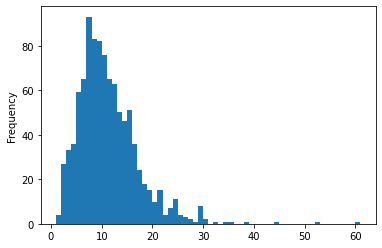

In [6]:
ax = df_text['word_count'].plot.hist(bins=60)
ax